# SUMMARY

## Hyperparameter: 
Number of Training Images

## Chosen Values/Variants:
To manipulate the number of training images I came up with two methods. The first approach would be to take the entire data set and only 
decrease/increase the proportion of test images. However, I decided against it because I wanted to keep the 80/20 (training/test) ratio 
for the various manipulations of the training data set. 
That's why I decided to take the approach of keeping the 80/20 (training/test) ratio for each variant to be able to compare the different
variants better and instead manipulated the transferred dataset in terms of its size (number of images to be processed).

I decided on the following 6 variants:

1. Variant: 500 images (400 training / 100 test)
2. Variant: 400 images (320 training / 80 test)
3. Variant: 300 images (240 training / 60 test)
4. Variant: 200 images (160 training / 40 test)
5. Variant: 100 images (80 training / 20 test)
6. Variant: using the complete dataset (about 630 images; 504 trainig / 126 test)

The retention of the 80/20 ratio and the same increments of 100 allow for a good comparison.

## Assumption
I assumed that the prediction accuracy for a test dataset improves the larger the training dataset is and at the same time the inference time 
for predictions decreases because the model is better trained and can make a prediction faster.

## Results

### 1. Variant: 500 images (400 training / 100 test)
loss: 0.0879 - accuracy: 0.9725 - val_loss: 0.2321 - val_accuracy: 0.9500 - lr: 2.0000e-04 (epoch 13/50)
inteference time for predictions: 13ms/step (4 steps)

### 2. Variant: 400 images (320 training / 80 test)
loss: 0.0370 - accuracy: 0.9875 - val_loss: 0.2103 - val_accuracy: 0.9250 - lr: 1.0000e-04 (epoch 16/50)
inteference time for predictions: 12ms/step (3 steps)

### 3. Variant: 300 images (240 training / 60 test)
loss: 0.0688 - accuracy: 0.9750 - val_loss: 0.1940 - val_accuracy: 0.9500 - lr: 2.0000e-04 (epoch 11/50)
inteference time for predictions: 16ms/step (2 steps)

### 4. Variant: 200 images (160 training / 40 test)
loss: 0.0947 - accuracy: 0.9750 - val_loss: 0.1310 - val_accuracy: 0.9750 - lr: 1.0000e-04 (epoch 32/50)
inteference time for predictions: 7ms/step (2 steps)

### 5. Variant: 100 images (80 training / 20 test)
loss: 0.5914 - accuracy: 0.7250 - val_loss: 0.4103 - val_accuracy: 0.9500 - lr: 2.0000e-04 (epoch 4/50)
inteference time for predictions: 57ms/step (1 step)

### 6. Variant: using the complete dataset (504 training / 126 test)
loss: 0.0861 - accuracy: 0.9863 - val_loss: 0.2305 - val_accuracy: 0.9297 - lr: 1.0000e-04 (epoch 21/50)
inteference time for predictions: 18ms/step (4 steps)

### Interpretation
Regarding the prediction accuracy for a test dataset training image datasets between 500 - 300 deliver similiar results with 
the model with the complete dataset (504 training images) having the best accuracy (and lowest loss). The interefence time for predictions
were between 18 and 12 ms per step. The variant with 160 training images achieves a good accuracy (0.9750) too but needed 32 epochs for it. 
Regarding the inteference time for predictions it had the lowest time with 7ms per step. The variant with 80 training images had the lowest 
accuracy (0.7250) and highest loss (0.5914). Furthermoore it had the highest inteference time for predictions with 57ms per step.

## Visualisation (TensorBoard)
The tools provided in the hyperparameter template were used for each variant to visualize and present the results. However, to get better comparability and 
more detailed information, I used a TensorBoard. A 'logs' folder is automatically created with the generation of the first model and the 
log files for each model variant are stored in it. With the help of this data, the individual models can then be viewed more closely in 
the TensorBoard and, above all, viewed visually very clearly.
The TensorBoard can be opened using the line of code I added at the end of the notebook.

An explanation of TensorBoards can be found at: 
https://www.youtube.com/watch?v=BqgTU7_cBnk&t=470s [10.05.23] (Analyzing Models with TensorBoard - Deep Learning with Python, TensorFlow and Keras p.4)

I didn't delete my logs folder in case you want to look into it / check my results (or start the TensorBoard) before you run the notebook.
Before you run the notebook please delete the logs folder. Every saved model has a unique id so no bug gonna occure but to prevent having models twice
afterwards its recommended to delete the logs folder to get a fresh logs folder.

## Further Informations

In order to be able to use the 5 variants in which the data set is manipulated without unnecessarily bloating the notebook, I have combined the methods 
from the template into a 'Pre-Build' block to functions, which I can then later call including a datasize parameter.


# Imports

In [1]:
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import random
import time

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomContrast, RandomBrightness

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import pre-trained model
from keras.applications.vgg16 import VGG16

# include only those gestures
CONDITIONS = ['like', 'stop']

# image size
IMG_SIZE = 64
SIZE = (IMG_SIZE, IMG_SIZE)

# number of color channels we want to use
# set to 1 to convert to grayscale
# set to 3 to use color images
COLOR_CHANNELS = 3

# Variants

In [2]:
FIRST_VARIANT = 500
SECOND_VARIANT = 400
THIRD_VARIANT =  300
FOURTH_VARIANT = 200
FIFTH_VARIANT = 100
# SIXTH_VARIANT is the complete dataset (about 630 images)

# Pre-build

## helper function to load and parse annotations

In [3]:
annotations = dict()

for condition in CONDITIONS:
    with open(f'_annotations/{condition}.json') as f:
        annotations[condition] = json.load(f)

## helper function to pre-process images (color channel conversion and resizing)

In [4]:
def preprocess_image(img):
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, SIZE)
    return img_resized

## load images and annotations

In [5]:
images = [] # stores actual image data
labels = [] # stores labels (as integer - because this is what our network needs)
label_names = [] # maps label ints to their actual categories so we can understand predictions later

# loop over all conditions
# loop over all files in the condition's directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists
for condition in CONDITIONS:
    for filename in tqdm(os.listdir(condition)):
        # extract unique ID from file name
        UID = filename.split('.')[0]
        img = cv2.imread(f'{condition}/{filename}')
        
        # get annotation from the dict we loaded earlier
        try:
            annotation = annotations[condition][UID]
        except Exception as e:
            print(e)
            continue
        
        # iterate over all hands annotated in the image
        for i, bbox in enumerate(annotation['bboxes']):
            # annotated bounding boxes are in the range from 0 to 1
            # therefore we have to scale them to the image size
            x1 = int(bbox[0] * img.shape[1])
            y1 = int(bbox[1] * img.shape[0])
            w = int(bbox[2] * img.shape[1])
            h = int(bbox[3] * img.shape[0])
            x2 = x1 + w
            y2 = y1 + h
            
            # crop image to the bounding box and apply pre-processing
            crop = img[y1:y2, x1:x2]
            preprocessed = preprocess_image(crop)
            
            # get the annotated hand's label
            # if we have not seen this label yet, add it to the list of labels
            label = annotation['labels'][i]
            if label not in label_names:
                label_names.append(label)
            
            label_index = label_names.index(label)
            
            images.append(preprocessed)
            labels.append(label_index)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

## Quick test if images are loaded

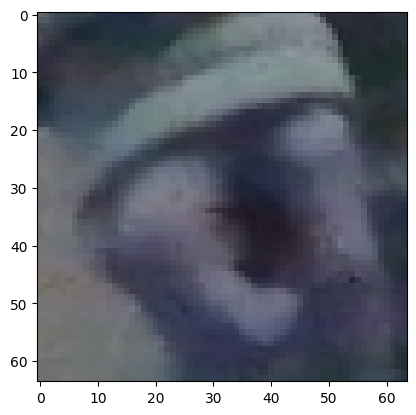

In [6]:
plt.imshow(random.sample(images, 1)[0])

## Builds the model 
Takes a data size parameter and returns the model and the history

In [7]:
def train_model(dataset_size):

    X_train, X_test, y_train, y_test = train_test_split(images[:dataset_size], labels[:dataset_size], test_size=0.2, random_state=42)

    print("training and test data")
    print(len(X_train))
    print(len(X_test))
    print(len(y_train))
    print(len(y_test))

    X_train = np.array(X_train).astype('float32')
    X_train = X_train / 255.

    X_test = np.array(X_test).astype('float32')
    X_test = X_test / 255.

    y_train_one_hot = to_categorical(y_train, 3)
    y_test_one_hot = to_categorical(y_test, 3)

    train_label = y_train_one_hot
    test_label = y_test_one_hot

    X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
    X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

    print("transformed data")
    print(X_train.shape, X_test.shape, train_label.shape, test_label.shape)

    # variables for hyperparameters
    batch_size = 8
    epochs = 50
    num_classes = len(label_names)
    activation = 'relu'
    activation_conv = 'LeakyReLU'  # LeakyReLU
    layer_count = 2
    num_neurons = 64

    # define model structure
    # with keras, we can use a model's add() function to add layers to the network one by one
    model = Sequential()

    # data augmentation (this can also be done beforehand - but don't augment the test dataset!)
    model.add(RandomFlip('horizontal'))
    model.add(RandomContrast(0.1))
    #model.add(RandomBrightness(0.1))
    #model.add(RandomRotation(0.2))

    # first, we add some convolution layers followed by max pooling
    model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
    model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

    model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
    model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

    model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    # dropout layers can drop part of the data during each epoch - this prevents overfitting
    model.add(Dropout(0.2))

    # after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
    model.add(Flatten())

    # add some fully connected layers ("Dense")
    for i in range(layer_count - 1):
        model.add(Dense(num_neurons, activation=activation))

    model.add(Dense(num_neurons, activation=activation))

    # for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
    model.add(Dense(num_classes, activation='softmax'))

    # specify loss function, optimizer and evaluation metrics
    # for classification, categorial crossentropy is used as a loss function
    # use the adam optimizer unless you have a good reason not to
    model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

    # define callback functions that react to the model's behavior during training
    # in this example, we reduce the learning rate once we get stuck and early stopping
    # to cancel the training if there are no improvements for a certain amount of epochs
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
    stop_early = EarlyStopping(monitor='val_loss', patience=3)
    tensordboard = TensorBoard(log_dir='logs/{}'.format("gesture_recognition_model-{}-images-version-{}".format(dataset_size, time.time())))

    history = model.fit(
        X_train,
        train_label,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(X_test, test_label),
        callbacks=[reduce_lr, stop_early, tensordboard]
    )

    return history, model, X_test, y_test



## Plot accuracy and loss of the training process and shows a summary of the model

In [8]:
def show_training_results(history, model):

    model.summary()

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    fig = plt.figure(figsize=(15, 7))
    ax = plt.gca()

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

    ax.axhline(1, color='gray')

    plt.plot(accuracy, color='blue')
    plt.plot(val_accuracy, color='orange')
    plt.plot(loss, '--', color='blue', alpha=0.5)
    plt.plot(val_loss, '--', color='orange', alpha=0.5)

# 1. Variant: 500 images (400 training / 100 test)

In [9]:
history, model, X_test, y_test = train_model(FIRST_VARIANT)

training and test data
400
100
400
100
transformed data
(400, 64, 64, 3) (100, 64, 64, 3) (400, 3) (100, 3)
Epoch 1/50
50/50 [==============================] - 3s 41ms/step - loss: 1.0423 - accuracy: 0.4875 - val_loss: 1.0426 - val_accuracy: 0.4400 - lr: 0.0010
Epoch 2/50
50/50 [==============================] - 2s 37ms/step - loss: 1.0109 - accuracy: 0.5050 - val_loss: 1.0222 - val_accuracy: 0.4400 - lr: 0.0010
Epoch 3/50
50/50 [==============================] - 2s 37ms/step - loss: 0.8589 - accuracy: 0.5725 - val_loss: 0.9393 - val_accuracy: 0.4900 - lr: 0.0010
Epoch 4/50
50/50 [==============================] - 2s 37ms/step - loss: 0.6849 - accuracy: 0.7025 - val_loss: 0.6091 - val_accuracy: 0.7900 - lr: 0.0010
Epoch 5/50
50/50 [==============================] - 2s 37ms/step - loss: 0.5798 - accuracy: 0.7650 - val_loss: 0.5216 - val_accuracy: 0.7800 - lr: 0.0010
Epoch 6/50
50/50 [==============================] - 2s 38ms/step - loss: 0.4384 - accuracy: 0.8125 - val_loss: 0.3375 - va

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 64, 64, 3)         0         
                                                                 
 random_contrast (RandomCont  (None, 64, 64, 3)        0         
 rast)                                                           
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        15616     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        51232     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0

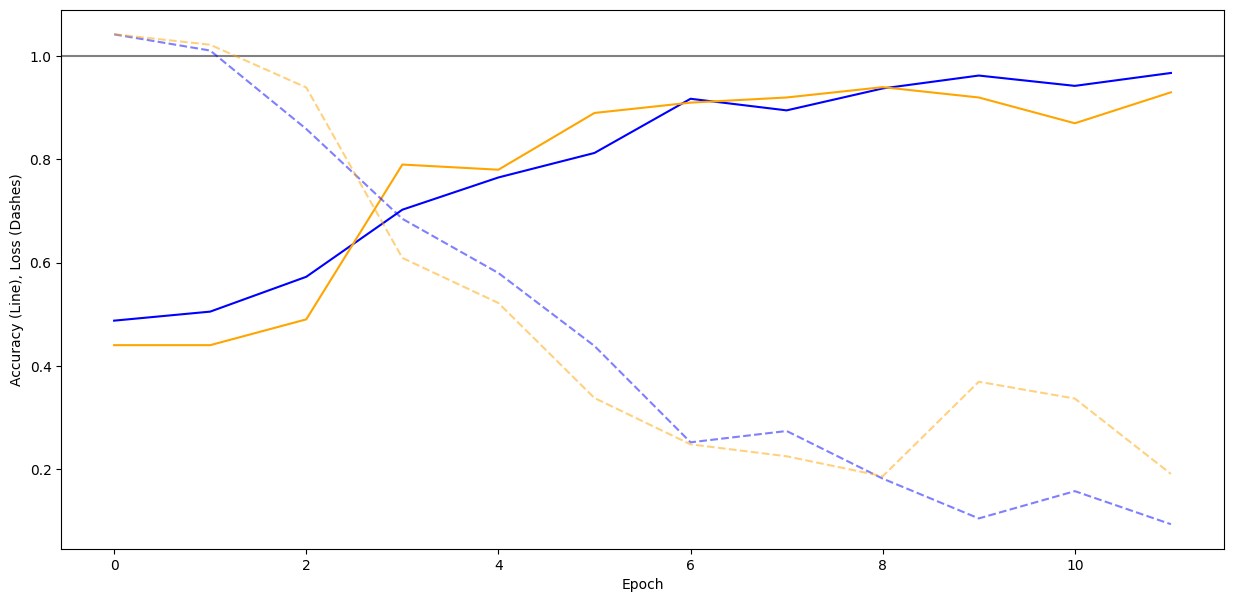

In [10]:
show_training_results(history, model)

In [11]:
y_predictions = model.predict(X_test)

4/4 [==============================] - 0s 12ms/step


# 2. Variant: 400 images (320 training / 80 test)

In [12]:
history, model, X_test, y_test  = train_model(SECOND_VARIANT)

training and test data
320
80
320
80
transformed data
(320, 64, 64, 3) (80, 64, 64, 3) (320, 3) (80, 3)
Epoch 1/50
40/40 [==============================] - 3s 39ms/step - loss: 0.9589 - accuracy: 0.5844 - val_loss: 0.9627 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/50
40/40 [==============================] - 1s 36ms/step - loss: 0.8673 - accuracy: 0.6250 - val_loss: 0.8614 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/50
40/40 [==============================] - 1s 36ms/step - loss: 0.7967 - accuracy: 0.6562 - val_loss: 0.7077 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 4/50
40/40 [==============================] - 1s 36ms/step - loss: 0.6274 - accuracy: 0.7531 - val_loss: 0.6721 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 5/50
40/40 [==============================] - 1s 36ms/step - loss: 0.5154 - accuracy: 0.7625 - val_loss: 0.4298 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 6/50
40/40 [==============================] - 1s 36ms/step - loss: 0.4199 - accuracy: 0.8375 - val_loss: 0.3411 - val_ac

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (8, 64, 64, 3)            0         
                                                                 
 random_contrast_1 (RandomCo  (None, 64, 64, 3)        0         
 ntrast)                                                         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        15616     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 32)        51232     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 32)        

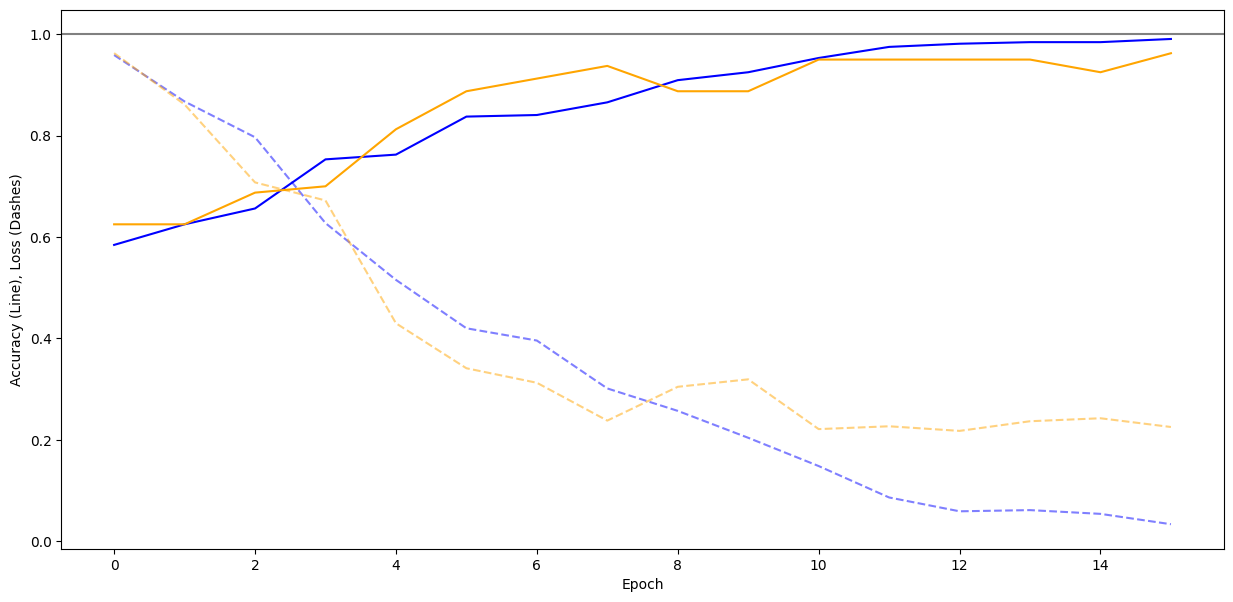

In [13]:
show_training_results(history, model)

In [14]:
y_predictions = model.predict(X_test)

3/3 [==============================] - 0s 13ms/step


# 3. Variant: 300 images (240 training / 60 test)

In [15]:
history, model, X_test, y_test  = train_model(THIRD_VARIANT)

training and test data
240
60
240
60
transformed data
(240, 64, 64, 3) (60, 64, 64, 3) (240, 3) (60, 3)
Epoch 1/50
30/30 [==============================] - 3s 41ms/step - loss: 0.5771 - accuracy: 0.7333 - val_loss: 0.4664 - val_accuracy: 0.8167 - lr: 0.0010
Epoch 2/50
30/30 [==============================] - 1s 36ms/step - loss: 0.5579 - accuracy: 0.7583 - val_loss: 0.5822 - val_accuracy: 0.8167 - lr: 0.0010
Epoch 3/50
30/30 [==============================] - 1s 36ms/step - loss: 0.5086 - accuracy: 0.7750 - val_loss: 0.4385 - val_accuracy: 0.8167 - lr: 0.0010
Epoch 4/50
30/30 [==============================] - 1s 36ms/step - loss: 0.4620 - accuracy: 0.7750 - val_loss: 0.4230 - val_accuracy: 0.8167 - lr: 0.0010
Epoch 5/50
30/30 [==============================] - 1s 36ms/step - loss: 0.4171 - accuracy: 0.7708 - val_loss: 0.3463 - val_accuracy: 0.8167 - lr: 0.0010
Epoch 6/50
30/30 [==============================] - 1s 36ms/step - loss: 0.3589 - accuracy: 0.8417 - val_loss: 0.2916 - val_ac

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (None, 64, 64, 3)         0         
                                                                 
 random_contrast_2 (RandomCo  (None, 64, 64, 3)        0         
 ntrast)                                                         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 64)        15616     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 32)        51232     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 6, 6, 32)        

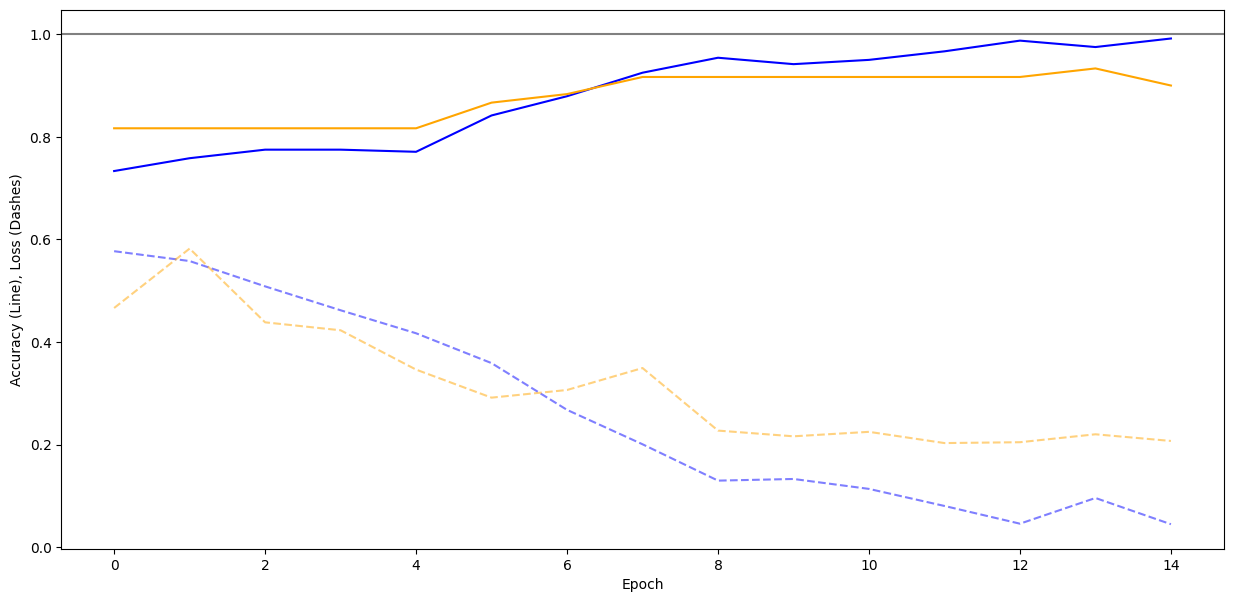

In [16]:
show_training_results(history, model)

In [17]:
y_predictions = model.predict(X_test)

2/2 [==============================] - 0s 14ms/step


# 4. Variant: 200 images (160 training / 40 test)

In [18]:
history, model, X_test, y_test  = train_model(FOURTH_VARIANT)

training and test data
160
40
160
40
transformed data
(160, 64, 64, 3) (40, 64, 64, 3) (160, 3) (40, 3)
Epoch 1/50
20/20 [==============================] - 2s 45ms/step - loss: 0.6595 - accuracy: 0.7063 - val_loss: 0.4874 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 2/50
20/20 [==============================] - 1s 38ms/step - loss: 0.5582 - accuracy: 0.7500 - val_loss: 0.4468 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 3/50
20/20 [==============================] - 1s 39ms/step - loss: 0.5042 - accuracy: 0.7688 - val_loss: 0.4609 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 4/50
20/20 [==============================] - 1s 38ms/step - loss: 0.5167 - accuracy: 0.7750 - val_loss: 0.4556 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 5/50
20/20 [==============================] - 1s 38ms/step - loss: 0.4901 - accuracy: 0.7688 - val_loss: 0.4283 - val_accuracy: 0.8000 - lr: 2.0000e-04
Epoch 6/50
20/20 [==============================] - 1s 38ms/step - loss: 0.4767 - accuracy: 0.7688 - val_loss: 0.4098 - va

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_3 (RandomFlip)  (8, 64, 64, 3)            0         
                                                                 
 random_contrast_3 (RandomCo  (None, 64, 64, 3)        0         
 ntrast)                                                         
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 64)        15616     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 32)        51232     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 6, 6, 32)        

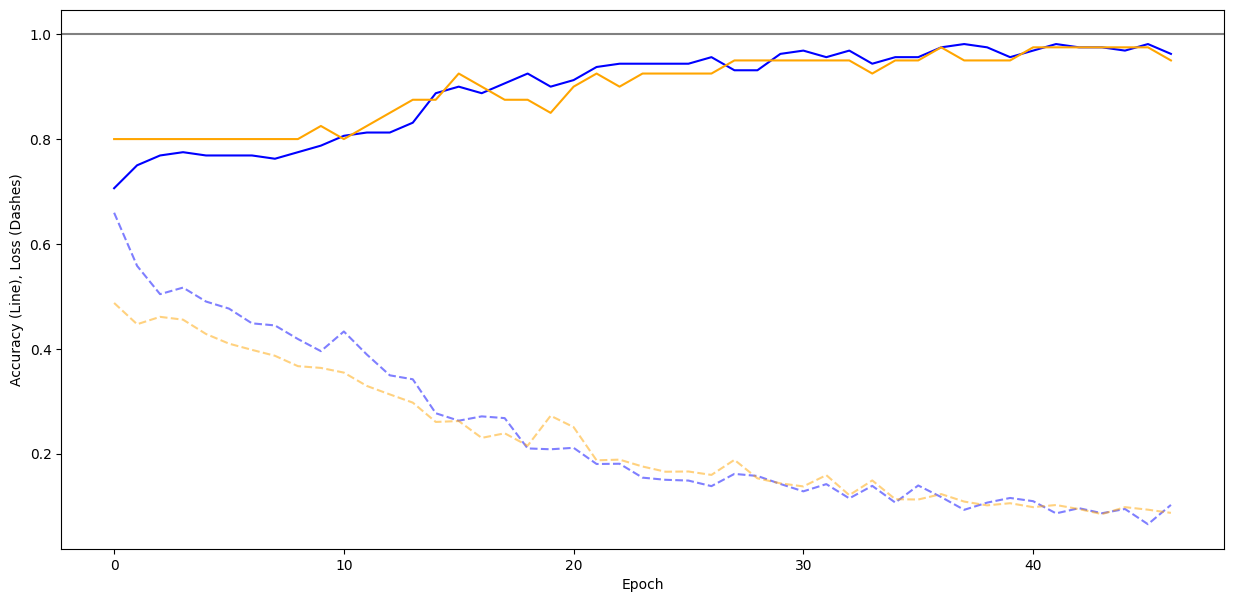

In [19]:
show_training_results(history, model)

In [20]:
y_predictions = model.predict(X_test)

2/2 [==============================] - 0s 7ms/step


# 5. Variant: 100 images (80 training / 20 test)

In [21]:
history, model, X_test, y_test  = train_model(FIFTH_VARIANT)

training and test data
80
20
80
20
transformed data
(80, 64, 64, 3) (20, 64, 64, 3) (80, 3) (20, 3)
Epoch 1/50
10/10 [==============================] - 2s 53ms/step - loss: 0.8472 - accuracy: 0.6500 - val_loss: 0.6842 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 2/50
10/10 [==============================] - 0s 40ms/step - loss: 0.6370 - accuracy: 0.6750 - val_loss: 0.2740 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 3/50
10/10 [==============================] - 0s 40ms/step - loss: 0.6236 - accuracy: 0.7125 - val_loss: 0.4431 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 4/50
10/10 [==============================] - 0s 40ms/step - loss: 0.6160 - accuracy: 0.7250 - val_loss: 0.3205 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 5/50
10/10 [==============================] - 0s 39ms/step - loss: 0.5450 - accuracy: 0.7000 - val_loss: 0.3660 - val_accuracy: 0.9500 - lr: 2.0000e-04


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_4 (RandomFlip)  (None, 64, 64, 3)         0         
                                                                 
 random_contrast_4 (RandomCo  (None, 64, 64, 3)        0         
 ntrast)                                                         
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 64, 64)        15616     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 32)        51232     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 6, 6, 32)        

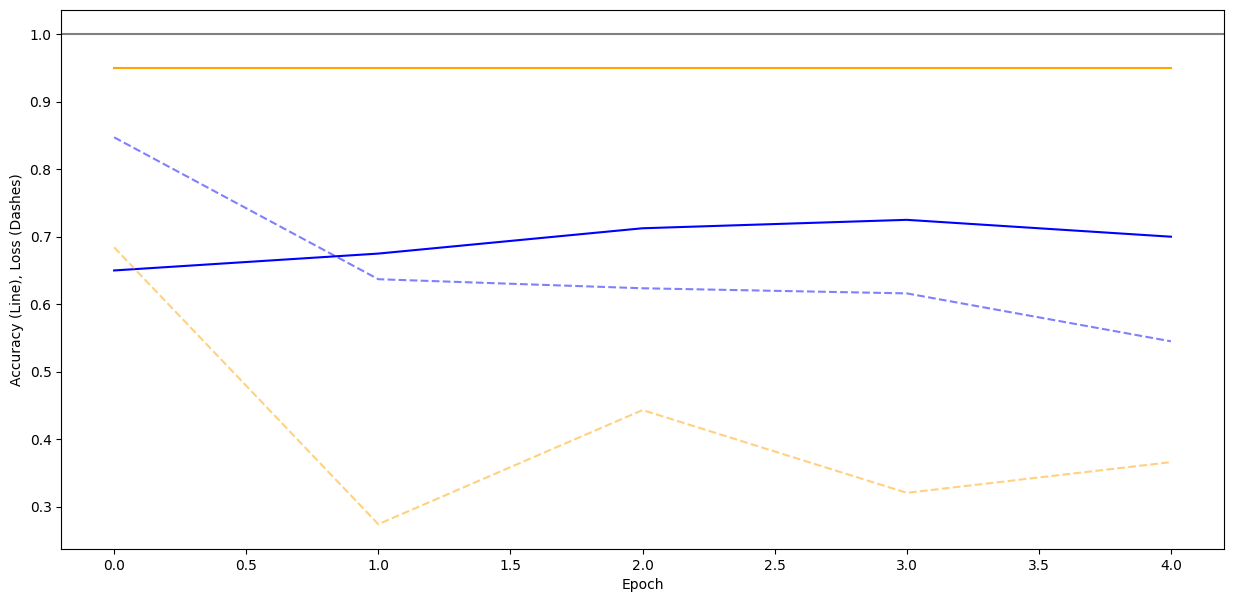

In [22]:
show_training_results(history, model)

In [23]:
y_predictions = model.predict(X_test)

1/1 [==============================] - 0s 58ms/step


# 6. Variant: using the complete dataset (about 630 images; 504 trainig / 126 test)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print("training and test data")
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

X_train = np.array(X_train).astype('float32')
X_train = X_train / 255.

X_test = np.array(X_test).astype('float32')
X_test = X_test / 255.

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

train_label = y_train_one_hot
test_label = y_test_one_hot

X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

print("transformed data")
print(X_train.shape, X_test.shape, train_label.shape, test_label.shape)

# variables for hyperparameters
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'LeakyReLU'  # LeakyReLU
layer_count = 2
num_neurons = 64

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation))

model.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)
tensordboard = TensorBoard(log_dir='logs/{}'.format("gesture_recognition_model-complete-dataset-version-{}".format(time.time())))

history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early, tensordboard]
)

training and test data
512
128
512
128
transformed data
(512, 64, 64, 3) (128, 64, 64, 3) (512, 3) (128, 3)
Epoch 1/50
64/64 [==============================] - 4s 38ms/step - loss: 1.0598 - accuracy: 0.4102 - val_loss: 1.0571 - val_accuracy: 0.3594 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - 2s 36ms/step - loss: 1.0174 - accuracy: 0.4785 - val_loss: 0.9514 - val_accuracy: 0.4375 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - 2s 36ms/step - loss: 0.8209 - accuracy: 0.6270 - val_loss: 0.7305 - val_accuracy: 0.7266 - lr: 0.0010
Epoch 4/50
64/64 [==============================] - 2s 36ms/step - loss: 0.6422 - accuracy: 0.7402 - val_loss: 0.6113 - val_accuracy: 0.7656 - lr: 0.0010
Epoch 5/50
64/64 [==============================] - 2s 36ms/step - loss: 0.5185 - accuracy: 0.8066 - val_loss: 0.3301 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 6/50
64/64 [==============================] - 2s 36ms/step - loss: 0.3297 - accuracy: 0.8828 - val_loss: 0.4499 - va

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_5 (RandomFlip)  (8, 64, 64, 3)            0         
                                                                 
 random_contrast_5 (RandomCo  (None, 64, 64, 3)        0         
 ntrast)                                                         
                                                                 
 conv2d_15 (Conv2D)          (None, 64, 64, 64)        15616     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 32)        51232     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 6, 6, 32)        

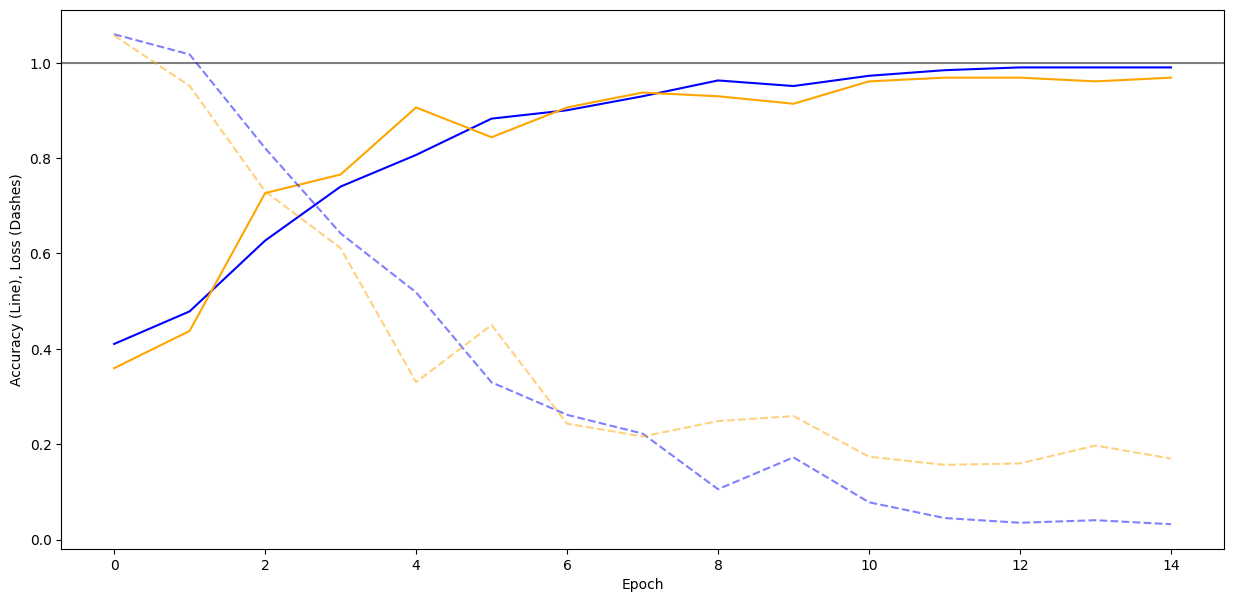

In [25]:
show_training_results(history, model)

## saving the model

the function will create a directory for your model and save structure and weights in there

sometimes you will see the .h5 format being used - even though this is a bit faster and needs less space, it comes with its limitations and isn't used that much any more

In [ ]:
model.save('gesture_recognition')

# and this is how you load the model
# model = keras.models.load_model("gesture_recognition")

## visualize classification results with a confusion matrix

In [26]:
y_predictions = model.predict(X_test)

4/4 [==============================] - 0s 15ms/step


## Confusion Matrix

before [[2.97269523e-01 1.44897145e-03 7.01281488e-01]
 [9.99917150e-01 7.93248400e-05 3.56022224e-06]
 [9.99832630e-01 1.31340799e-04 3.59491351e-05]
 [9.56678850e-05 2.32668135e-05 9.99881029e-01]
 [9.99718726e-01 2.61291454e-04 2.00130671e-05]
 [9.99999046e-01 9.46694058e-07 4.24085433e-10]
 [9.99999762e-01 2.94756802e-07 2.75323431e-09]
 [3.10061157e-01 6.89914942e-01 2.39075744e-05]
 [9.99963522e-01 3.44715700e-05 1.99363217e-06]
 [9.99532700e-01 4.33555484e-04 3.37428028e-05]
 [7.30077212e-04 3.03978995e-05 9.99239564e-01]
 [7.23302321e-07 9.99999046e-01 2.04247840e-07]
 [9.17445898e-01 6.57477900e-02 1.68062281e-02]
 [2.30777427e-04 3.10892850e-04 9.99458373e-01]
 [9.99999762e-01 1.97495737e-07 8.23788399e-11]
 [3.73702751e-05 5.36685657e-05 9.99908924e-01]
 [1.32400794e-06 9.99998212e-01 4.43197877e-07]
 [2.93649297e-04 9.68678160e-06 9.99696732e-01]
 [3.79531615e-04 9.99435484e-01 1.84958888e-04]
 [7.03312799e-06 9.96149311e-07 9.99992013e-01]
 [5.11507213e-01 1.58826351e-01 3

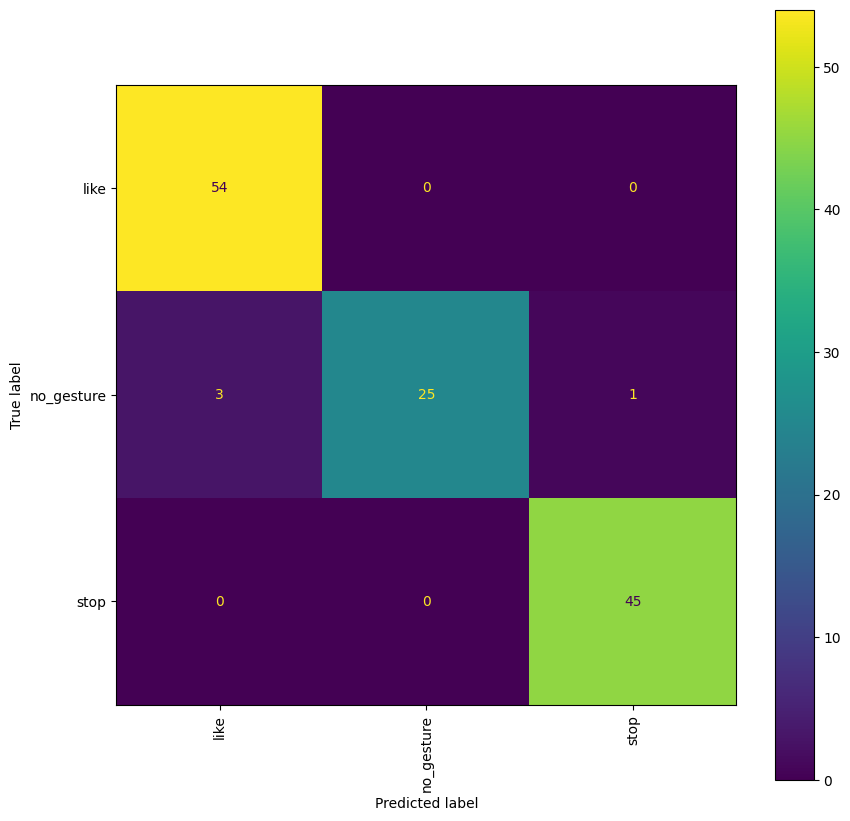

In [27]:
# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

# Show TensorBoard

In [ ]:
%tensorboard --logdir logs/fit